# Notebook Nettoyage Texte
Le but de ce notebook est d'extraire des features à partir de la description des produits. 

## Sommaire :
- [A - Tokenisation](#A)
- [B - Nettoyage Description](#B)
- [B.1 - Retrait des Stop Words](#B.1)
- [B.2 - Stemming & Lemmatising](#B.2)
- [C - Extraction Catégorie de Produit](#C)
- [D - Bag of Words & Tf-Idf](#D)
- [E - Visualisations](#E)
- [F - Enregistrement du fichier](#F)

## Chargement bibliothèques & fonctions 

In [216]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.manifold import TSNE

In [217]:
def recap(df):
    return pd.concat([df.describe(include='all'), df.dtypes.to_frame(name='type').T])

def moda(df,col):
    """
    - Paramètres : 
        - Dataframe
        - Colonne du Dataframe
    - Retourne : Dataframe des modalités de la colonne et du dataframe en entrée avec leur fréquences et leurs effectifs respectifs
    """
    #on comptes le nombre de valeurs dans la colonne
    eff = df[col].value_counts() 
    #on récupères les modalités que prends la variable
    moda = eff.index 
    
    #on crée un DataFrame avec toutes les modalités de la variable
    tab_moda = pd.DataFrame(moda, columns = [col])
    #On ajoute une colonne au DataFrame contenant le nombre d'occurence de la modalité
    tab_moda["n"] = eff.values
    #on ajoute une colonne au DataFrame colculant la fréquence d'apparition de la modalité
    tab_moda["f"] = tab_moda["n"]/sum(tab_moda["n"])*100 
    return tab_moda

def diagbar(df,col):
    """
    - Paramètres : 
        - Dataframe
        - Colonne du Dataframe
    - Retourne : Diagramme en barre de la colonne du dataframe passés en entrée
    """
    plt.figure(figsize=(10,5))
    bp=sns.barplot(x=df[col],y=df['f'],palette='Spectral')
    bp.set_xticklabels(labels=df[col],rotation=90)
    plt.show()

## Chargement fichier

In [218]:
desc = pd.read_csv("Data/desc.csv")

In [219]:
len(desc)

1050

On a donc 1050 produits en tout.

In [220]:
desc

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [221]:
recap(desc)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1049,1049,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,NaN,NaN,1050,2,1050,27,27,490,984
top,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-01 12:40:44 +0000,http://www.flipkart.com/mohanjodero-jewellery-...,Oshea Herbals UVSHIELD - Sunscreen Gel - SPF 2...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",PACE43HFHCYGHYFK,NaN,NaN,00e966a5049a262cfc72e6bbf68b80e7.jpg,False,Buy Oxyglow Bearberry Face Wash & Fruit Massag...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,NaN,NaN,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,NaN,2186.2,1584.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,7639.23,7475.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,555,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,999,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1999,1199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Traitement du texte - Description
On va ici procéder à un traitement de texte pour extraire des features pour chaques produit. L'idée est de traiter uniquement la description des produits.
### A - Tokenisation <a name=A ></a>
Découpage du texte en mots séparés, en prenant soin de retirer la ponctuation et les caractères tels que les apostrophes et les chiffres. On en profites aussi pour mettre le texte en minsucule pour uniformiser le corpus.

In [222]:
#définition du Tokenizer 
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [223]:
#retrait chiffres
desc['description'] = desc['description'].apply(lambda x: re.sub(r'\d+', '', x))

In [224]:
#lower text + tokenize
desc['description'] = desc['description'].str.lower().apply(lambda x: tokenizer.tokenize(x))

### B - Nettoyage <a name=B ></a> 
On va nettoyer le corpus de mots que l'on à extrait précèdement en retirant les "stop words" c'est à dire les mots qui n'apportent pas de valeur ajouté à notre corpus comme les mots de liaisons etc...
Ensuite on va procéder à la racinisation (Steming) ou à la Lemmatisation afin réduire le nombre de mots différents en ramenant les mots qui sont proches en un même mot. 

#### B.1 - Retrait des Stop Words <a name=B.1 ></a>

In [225]:
#on récupère un ensemble de stop words dans la langue anglaise via la bibliothèque NLTK
stop_words = set(stopwords.words('english'))

In [226]:
#on créer une colonne 'description_cleaned' avec les mots de 'description' qui ne font pas partie des stop words
desc['description_cleaned'] = desc['description'].apply(
    lambda x: [w for w in x if not w in stop_words and w.isalpha()])

#### B.2 - Stemming & Lemmatising <a name=B.2 ></a>
Avant de procéder à la racinisation (Steming) ou à la Lemmatisation on va tester les 2 méthodes et décider en fonction des résultats.

In [227]:
#def lemmatizer & stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [228]:
#comparaison stemmer/lemmatizer
for i in range(len(desc['description_cleaned'][0])):
    print(desc['description_cleaned'][0][i],' ---> ',lemmatizer.lemmatize(desc['description_cleaned'][0][i]),
          ' / ', stemmer.stem(desc['description_cleaned'][0][i]) )

key  --->  key  /  key
features  --->  feature  /  featur
elegance  --->  elegance  /  eleg
polyester  --->  polyester  /  polyest
multicolor  --->  multicolor  /  multicolor
abstract  --->  abstract  /  abstract
eyelet  --->  eyelet  /  eyelet
door  --->  door  /  door
curtain  --->  curtain  /  curtain
floral  --->  floral  /  floral
curtain  --->  curtain  /  curtain
elegance  --->  elegance  /  eleg
polyester  --->  polyester  /  polyest
multicolor  --->  multicolor  /  multicolor
abstract  --->  abstract  /  abstract
eyelet  --->  eyelet  /  eyelet
door  --->  door  /  door
curtain  --->  curtain  /  curtain
cm  --->  cm  /  cm
height  --->  height  /  height
pack  --->  pack  /  pack
price  --->  price  /  price
rs  --->  r  /  rs
curtain  --->  curtain  /  curtain
enhances  --->  enhances  /  enhanc
look  --->  look  /  look
interiors  --->  interior  /  interior
curtain  --->  curtain  /  curtain
made  --->  made  /  made
high  --->  high  /  high
quality  --->  quality  /  qua

J'ai choisi d'utiliser le lemmatizer plutôt que le stemmer car je trouves qu'avec le stemming on perd de de l'information. Par exemple : elegance  --->  elegance  /  eleg <br>
Lemmatisation de la description :

In [229]:
#lemmatisation
desc['description_lemmatized'] = desc['description_cleaned'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [230]:
#stemming
desc['description_stemmed'] = desc['description_cleaned'].apply(lambda x: [stemmer.stem(w) for w in x])

In [231]:
desc

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,description_cleaned,description_lemmatized,description_stemmed
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"[key, features, of, elegance, polyester, multi...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[key, features, elegance, polyester, multicolo...","[key, feature, elegance, polyester, multicolor...","[key, featur, eleg, polyest, multicolor, abstr..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"[specifications, of, sathiyas, cotton, bath, t...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[specifications, sathiyas, cotton, bath, towel...","[specification, sathiyas, cotton, bath, towel,...","[specif, sathiya, cotton, bath, towel, bath, t..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"[key, features, of, eurospa, cotton, terry, fa...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[key, features, eurospa, cotton, terry, face, ...","[key, feature, eurospa, cotton, terry, face, t...","[key, featur, eurospa, cotton, terri, face, to..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"[key, features, of, santosh, royal, fashion, c...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[key, features, santosh, royal, fashion, cotto...","[key, feature, santosh, royal, fashion, cotton...","[key, featur, santosh, royal, fashion, cotton,..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"[key, features, of, jaipur, print, cotton, flo...",No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...","[key, features, jaipur, print, cotton, floral,...","[key, feature, jaipur, print, cotton, floral, ...","[key, featur, jaipur, print, cotton, floral, k..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,"[oren, empower, extra, large, self, adhesive, ...",No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...","[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ...","[oren, empow, extra, larg, self, adhes, sticke..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,h

In [232]:
desc['description_stemmed'][100]

['buy',
 'goldencollect',
 'gc',
 'makeup',
 'jewelleri',
 'vaniti',
 'pouch',
 'rs',
 'onlin',
 'goldencollect',
 'gc',
 'makeup',
 'jewelleri',
 'vaniti',
 'pouch',
 'best',
 'price',
 'free',
 'ship',
 'cash',
 'deliveri',
 'genuin',
 'product',
 'day',
 'replac',
 'guarante']

### C - Extraction Catégorie de Produit <a name=C ></a>
S'agissant d'une classification non-supervisée on ne va pas pourvoir se servir de la catégorie des produits pour effectuer le clustering. Par contre, la catégorie de produit va pouvoir nous permetttre de juger de la qualité du clustering effectué.

In [233]:
for i in range(30,50):
    print(desc['product_category_tree'][i])

["Watches >> Wrist Watches >> Marvel Wrist Watches"]
["Watches >> Wrist Watches >> Lenco Wrist Watches"]
["Watches >> Wrist Watches >> D'Signer Wrist Watches"]
["Home Furnishing >> Living Room Furnishing >> Diwan Sets >> SANTOSH ROYAL FASHION Diwan Sets >> SANTOSH ROYAL FASHION Cotton Embroidered Diwan Set"]
["Home Furnishing >> Bed Linen >> Duvet Covers >> House This Duvet Covers >> House This Queen Cotton Duvet Cover (Grey)"]
["Home Furnishing >> Bath Linen >> Bath Mats"]
["Home Decor & Festive Needs >> Candles & Fragrances >> Home Fragrances >> Aroma Oils >> Myesquire Aroma Oils"]
["Kitchen & Dining >> Tableware & Cutlery >> Jug, Glass & Tray Sets >> Dungri India Craft Jug, Glass & Tray Sets >> Dungri India Craft Ducjug010-ducgl012-2 Jug Glas..."]
["Kitchen & Dining >> Lighting >> Bulbs >> BFT Bulbs >> BFT 6 W LED Bulb (White)"]
["Home Furnishing >> JMD Home Furnishing >> JMD Printed Cushions Cover (Pack of 2, 40 cm*40 ..."]
["Baby Care >> Infant Wear >> Baby Girls' Clothes >> Inner

On observe ici que la colonne 'product_category_tree' qui nous renseigne sur la catégorie du produit est sous la forme d'un "arbre". En effet, chaques catégories principale est composée de sous-catégories. De plus, on remarque que tout les arbres de catégories n'ont pas la même "profondeur". On va donc nettoyer le champ et regarder la distribution 

![title](product_tree.png)

In [234]:
def clean_cat(string,level):
    """
    Extrait la catégorie de la string passée en entrée sachant que les strings suivent le format suivant :
        ["Cat0 >> Cat1 >> Cat2 >> CatX >> NomProduit"] 
    Paramètres :
        - string : string contenant les catégories que l'on veut extraire
        - level : niveau de la catégorie que l'on cherche à extraire 
    Retourne : La nom de la catégorie
    """
    string = string.replace('["','')
    string = string.replace('"]','')
    string = string.replace(' ','')
    str_split=string.split(">>")
    return str_split[level]

1ère Maille :

In [235]:
moda(pd.DataFrame(desc['product_category_tree'].apply(lambda x: clean_cat(x,0))),'product_category_tree')

,product_category_tree,n,f
0,HomeFurnishing,150,14.285714
1,HomeDecor&FestiveNeeds,150,14.285714
2,BabyCare,150,14.285714
3,Computers,150,14.285714
4,Watches,150,14.285714
5,Kitchen&Dining,150,14.285714
6,BeautyandPersonalCare,150,14.285714


7 catégories parfaitement équilibrées avec 150 individus dans chaques catégories. <br>
2ème Maille :

In [236]:
sec_maille = moda(pd.DataFrame(desc['product_category_tree'].apply(lambda x: clean_cat(x,1))),'product_category_tree')
sec_maille

,product_category_tree,n,f
0,WristWatches,149,14.190476
1,LaptopAccessories,87,8.285714
2,InfantWear,84,8.000000
3,CoffeeMugs,74,7.047619
4,Showpieces,71,6.761905
...,...,...,...
57,Women'sHygiene,1,0.095238
58,PressureCookers&Pans,1,0.095238
59,BeautyAccessories,1,0.095238
60,Housekeeping&Laundry,1,0.095238


In [237]:
len(sec_maille[sec_maille['f']<1])

38

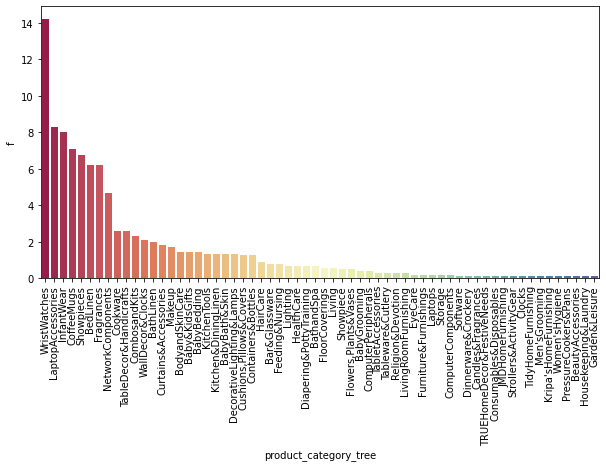

In [238]:
diagbar(moda(pd.DataFrame(desc['product_category_tree'].apply(lambda x: clean_cat(x,1))),'product_category_tree'),'product_category_tree')

Cette seconde maille est beaucoup plus déséquilibrée. On a 62 catégories avec des effectifs très variables passant de 14% pour la catégorie la plus représentée "Wrist Watches" à 8% pour la seconde "LaptopAccessories". Enfin on a 38 catégories, c'est à dire plus de la moitié, dont la fréquence est inférieure à 1%. <br>
Ce niveau de maille présente donc trop peut d'exemple de chaques catégories  pour que l'interprétation des catégories soit significative. On va donc partir sur la maille la plus grosse.

In [239]:
desc['clean_category'] = desc['product_category_tree'].apply(lambda x: clean_cat(x,0))

In [240]:
desc

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,description_cleaned,description_lemmatized,description_stemmed,clean_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"[key, features, of, elegance, polyester, multi...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[key, features, elegance, polyester, multicolo...","[key, feature, elegance, polyester, multicolor...","[key, featur, eleg, polyest, multicolor, abstr...",HomeFurnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"[specifications, of, sathiyas, cotton, bath, t...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[specifications, sathiyas, cotton, bath, towel...","[specification, sathiyas, cotton, bath, towel,...","[specif, sathiya, cotton, bath, towel, bath, t...",BabyCare
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"[key, features, of, eurospa, cotton, terry, fa...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[key, features, eurospa, cotton, terry, face, ...","[key, feature, eurospa, cotton, terry, face, t...","[key, featur, eurospa, cotton, terri, face, to...",BabyCare
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"[key, features, of, santosh, royal, fashion, c...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[key, features, santosh, royal, fashion, cotto...","[key, feature, santosh, royal, fashion, cotton...","[key, featur, santosh, royal, fashion, cotton,...",HomeFurnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"[key, features, of, jaipur, print, cotton, flo...",No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...","[key, features, jaipur, print, cotton, floral,...","[key, feature, jaipur, print, cotton, floral, ...","[key, featur, jaipur, print, cotton, floral, k...",HomeFurnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,"[oren, empower, extra, large, self, adhesive, ...",No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...","[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ...","[oren, empow, extra, larg, self, a

### D - Bag of Words & Tf-Idf <a name=D ></a>
On va maintenant créer un "Bag of Words" c'est à dire un ensemble de mot qui décrit chaque produit, simplement en créant une string à partir de la liste de mots de la description que l'on à nettoyé précèdement. 
Ensuite on va transformer le texte en valeurs numériques pour pouvoir effectuer notre clustering. On va effectuer cette transformation grâce à un Tf-Idf Vectorizer. <br>

Le Tf-Idf va permettre d'attribuer un poid à un mot du corpus en fonction de plusieurs critères :
- Tf : Term-Frequency c'est à dire la fréquence d'apparition du mot dans l'ensemble des description. Par exemple, le mot apparait 5 fois dans la 1ère description et 100 fois dans l'ensemble des documents, Tf = 5/100 
- Idf : Inverse Document Frequency c'est à dire l'inverse de la proportion de documents du corpus qui contiennent le terme, dont on va calculer le logarithme. Par exemple, si le terme apparait dans 20 documents sur 100 documents au total, Idf = log(100/20)

Le Tf-Idf résulte du produit Tf x Idf. Le Tf permettant de donner de l'importance aux mots qui apparaissent beaucoup mais cette métrique ne va donc pas prendre en compte les mots qui apparaissent peut mais qui pourrait rendre compte d'une particularité. C'est pour ça qu'on pondère le Tf grâce à l'Idf.

In [241]:
#Création du bag of words
desc['bow_lem'] = desc['description_lemmatized'].apply(lambda x: " ".join(x))
desc['bow_lem']

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel bath ...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker r ...
1049    buy uberlyfe large vinyl sticker r online uber...
Name: bow_lem, Length: 1050, dtype: object

In [242]:
#Création du bag of words
desc['bow_stem'] = desc['description_stemmed'].apply(lambda x: " ".join(x))
desc['bow_stem']

0       key featur eleg polyest multicolor abstract ey...
1       specif sathiya cotton bath towel bath towel re...
2       key featur eurospa cotton terri face towel set...
3       key featur santosh royal fashion cotton print ...
4       key featur jaipur print cotton floral king siz...
                              ...                        
1045    oren empow extra larg self adhes sticker pack ...
1046    wallmantra larg vinyl sticker sticker pack pri...
1047    buy uberlyf extra larg pigment polyvinyl film ...
1048    buy wallmantra medium vinyl sticker sticker rs...
1049    buy uberlyf larg vinyl sticker rs onlin uberly...
Name: bow_stem, Length: 1050, dtype: object

In [243]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [244]:
#Extraction des features avec Tf-Idf Vectorizer : min_df=0.01,max_df=0.8 
tfidf_lem = TfidfVectorizer(min_df=0.02,max_df=0.7)
tfidf_stem = TfidfVectorizer(min_df=0.02,max_df=0.7)

values_lem = tfidf_lem.fit_transform(desc['bow_lem'])
values_stem = tfidf_stem.fit_transform(desc['bow_stem'])

On va fixer des paramètres de min_df et max_df :
- min_df : seuil de document frequency, c'est a dire que l'on fixe un minimum de document dans lequel le mot doit apparaitre pour le conserver
- max_df : limite de document frequency, c'est le maximum de document dans lequel on veut que le mot apparaisse pour le conserver

In [245]:
values_tfidf_lem = pd.DataFrame(values_lem.toarray())
values_tfidf_lem

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,0.234519,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.582051,...,0.0,0.000000,0.0,0.000000,0.071375,0.076126,0.00000,0.198503,0.077785,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.131792,...,0.0,0.050665,0.0,0.000000,0.048483,0.051711,0.06103,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.182772,0.000000,0.00000,0.000000,0.066396,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.045646,0.0,0.162257,0.131043,0.000000,0.00000,0.000000,0.047604,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
1046,0.000000,0.0,0.0,0.120581,0.0,0.152189,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.108564,0.000000,0.00000,0.000000,0.000000,0.0
1047,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
1048,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0


In [246]:
dict(zip(tfidf_lem.get_feature_names(), values_lem.toarray()[0]))

{'abstract': 0.2345191843745035,
 'add': 0.0,
 'additional': 0.0,
 'also': 0.0,
 'analog': 0.0,
 'art': 0.0,
 'attractive': 0.0,
 'baby': 0.0,
 'back': 0.0,
 'bath': 0.0,
 'battery': 0.0,
 'beautiful': 0.0,
 'beautifully': 0.0,
 'best': 0.0,
 'black': 0.0,
 'blanket': 0.0,
 'bleach': 0.0,
 'blue': 0.0,
 'body': 0.052388987939219284,
 'bottle': 0.0,
 'box': 0.03429602777096449,
 'boy': 0.0,
 'brand': 0.03700645374124722,
 'brass': 0.0,
 'brown': 0.0,
 'buckle': 0.0,
 'buy': 0.0,
 'capacity': 0.0,
 'care': 0.0,
 'case': 0.0,
 'cash': 0.0,
 'casual': 0.0,
 'cell': 0.0,
 'ceramic': 0.0,
 'clasp': 0.0,
 'clean': 0.0,
 'cm': 0.11310719533856188,
 'code': 0.0,
 'coffee': 0.0,
 'collection': 0.0,
 'color': 0.03552504782038826,
 'colour': 0.0,
 'com': 0.0,
 'combo': 0.0,
 'come': 0.0,
 'comfort': 0.0,
 'comfortable': 0.0,
 'comforter': 0.0,
 'compatible': 0.0,
 'content': 0.04190925639563824,
 'cotton': 0.0,
 'cover': 0.0,
 'covered': 0.0,
 'crafting': 0.0,
 'creation': 0.0,
 'curtain': 0.75611

In [247]:
values_tfidf_stem = pd.DataFrame(values_stem.toarray())
values_tfidf_stem

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,0.220232,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.071460,0.076485,0.0,0.000000,0.198741,0.077879,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.047946,0.051317,0.0,0.060353,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.176701,0.000000,0.0,0.000000,0.000000,0.064191,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.158885,0.0,0.128320,0.000000,0.0,0.000000,0.000000,0.046615,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.000000,0.0,0.0,0.000000,0.0,0.438626,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1046,0.000000,0.0,0.0,0.101176,0.0,0.515051,0.127697,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.091093,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1047,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1048,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [248]:
test = pd.DataFrame(values_tfidf_stem.iloc[100])
test[test[100]>0].T

,15,29,33,62,65,90,94,104,162,180,183,191,205
100,0.407556,0.252023,0.255334,0.269933,0.254778,0.246919,0.255334,0.283669,0.313734,0.261592,0.228951,0.276492,0.255056


In [249]:
dict(zip(tfidf_stem.get_feature_names(), values_stem.toarray()[0]))

{'abstract': 0.22023179564844977,
 'add': 0.0,
 'addit': 0.0,
 'also': 0.0,
 'analog': 0.0,
 'appli': 0.0,
 'art': 0.0,
 'attract': 0.0,
 'avail': 0.0,
 'babi': 0.0,
 'back': 0.0,
 'base': 0.0,
 'bath': 0.0,
 'batteri': 0.0,
 'beauti': 0.049009194208406257,
 'best': 0.0,
 'black': 0.0,
 'blanket': 0.0,
 'bleach': 0.0,
 'blue': 0.0,
 'bodi': 0.049197343564160896,
 'bottl': 0.0,
 'box': 0.03220664356203418,
 'boy': 0.0,
 'brand': 0.0343128969509718,
 'brass': 0.0,
 'bring': 0.05695608245972972,
 'brown': 0.0,
 'buckl': 0.0,
 'buy': 0.0,
 'capac': 0.0,
 'care': 0.0,
 'case': 0.0,
 'cash': 0.0,
 'casual': 0.0,
 'cell': 0.0,
 'ceram': 0.0,
 'clasp': 0.0,
 'clean': 0.0,
 'cloth': 0.0,
 'cm': 0.10785765130357812,
 'code': 0.0,
 'coffe': 0.0,
 'collect': 0.0,
 'color': 0.03307674606703058,
 'colour': 0.0,
 'com': 0.0,
 'combo': 0.0,
 'come': 0.0,
 'comfort': 0.0,
 'compat': 0.0,
 'content': 0.039356058716133464,
 'cotton': 0.0,
 'cover': 0.0,
 'craft': 0.0,
 'creation': 0.0,
 'curtain': 0.7100

### E - Visualisations <a name=E ></a>
On va maintenant visualiser les features trasnformées par le Tf-Idf à l'aide d'un t-SNE. Le t-SNE va nous permettre de visualiser en 2 dimensions notre espace de 501 dimensions (features). L'idée va être de colorer les individus selon leur catégorie et analyser leur répartition sur le t-SNE pour juger de la qualité de la feature extraction.

In [250]:
# définition des couleurs
color = ['purple','deepskyblue','red','chocolate','darkorange','forestgreen','royalblue']

In [251]:
#on récupère la liste des catégories de chaques produits
categ = desc['clean_category']
categ

0       HomeFurnishing
1             BabyCare
2             BabyCare
3       HomeFurnishing
4       HomeFurnishing
             ...      
1045          BabyCare
1046          BabyCare
1047          BabyCare
1048          BabyCare
1049          BabyCare
Name: clean_category, Length: 1050, dtype: object

In [252]:
#t-SNE lem
tsne = TSNE(random_state=5) #perplexity=40
tsne_results_lem = tsne.fit_transform(values_tfidf_lem)
tsne_results_lem = pd.DataFrame(tsne_results_lem)
tsne_results_lem

,0,1
0,10.509926,10.496379
1,14.786308,23.859243
2,14.177003,24.885736
3,-3.807647,3.268243
4,-3.954592,3.403394
...,...,...
1045,-0.915201,-15.255430
1046,-0.075013,-15.464504
1047,28.641909,0.242538
1048,29.280668,0.614577


In [253]:
#t-SNE stem
tsne = TSNE(random_state=5) #perplexity=40
tsne_results_stem = tsne.fit_transform(values_tfidf_stem)
tsne_results_stem = pd.DataFrame(tsne_results_stem)
tsne_results_stem

,0,1
0,-2.347998,4.918041
1,19.097855,24.456638
2,18.842899,25.686852
3,0.522621,0.399189
4,0.541859,0.612944
...,...,...
1045,4.361205,-16.036348
1046,4.443790,-16.247849
1047,27.822174,-2.763057
1048,28.526562,-2.532756


<AxesSubplot:xlabel='0', ylabel='1'>

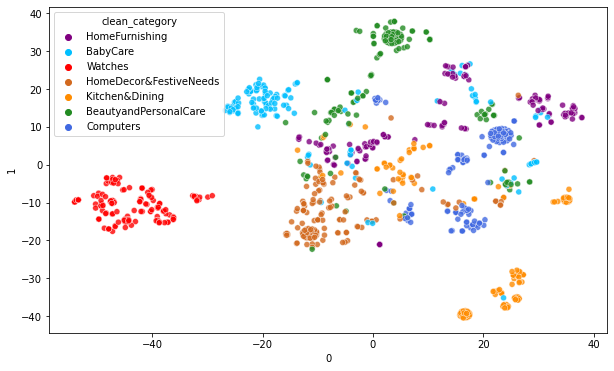

In [254]:
#Scatterplot des résultats du t-SNE
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=tsne_results_lem[0], y=tsne_results_lem[1],
    #on regroupe par les catégories les produits
    hue=categ, 
    palette=color,
    legend="full",
    alpha=0.8
)

<AxesSubplot:xlabel='0', ylabel='1'>

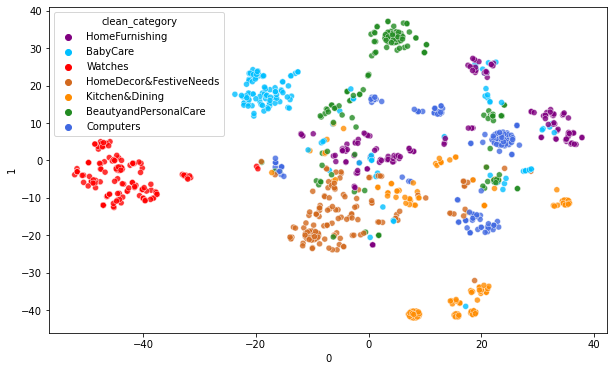

In [255]:
#Scatterplot des résultats du t-SNE
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=tsne_results_stem[0], y=tsne_results_stem[1],
    #on regroupe par les catégories les produits
    hue=categ, 
    palette=color,
    legend="full",
    alpha=0.8
)

On peut voir sur le graphique ci-dessus que les produits sont bien regroupés selon leurs catégories. Les features extraites grâce au Tf-Idf semble donc être pertinentes. 

### F - Enregistrement du fichier  <a name=F ></a>
On va maintenant enregistrer le fichier des descritpions néttoyé avec uniquement les colonnes qui nous intérrèssent. On va aussi enregistrer le résultat de notre Tf-Idf.

In [256]:
desc_clean = desc[['uniq_id','product_name','image','bow_lem','bow_stem','clean_category']]
desc_clean

,uniq_id,product_name,image,bow_lem,bow_stem,clean_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key feature elegance polyester multicolor abst...,key featur eleg polyest multicolor abstract ey...,HomeFurnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,specification sathiyas cotton bath towel bath ...,specif sathiya cotton bath towel bath towel re...,BabyCare
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,key feature eurospa cotton terry face towel se...,key featur eurospa cotton terri face towel set...,BabyCare
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,key feature santosh royal fashion cotton print...,key featur santosh royal fashion cotton print ...,HomeFurnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,key feature jaipur print cotton floral king si...,key featur jaipur print cotton floral king siz...,HomeFurnishing
...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,oren empower extra large self adhesive sticker...,oren empow extra larg self adhes sticker pack ...,BabyCare
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,wallmantra large vinyl sticker sticker pack pr...,wallmantra larg vinyl sticker sticker pack pri...,BabyCare
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyf extra larg pigment polyvinyl film ...,BabyCare
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,buy wallmantra medium vinyl sticker sticker r ...,buy wallmantra medium vinyl sticker sticker rs...,BabyCare


In [257]:
desc_clean.to_csv("Data/data_txt.csv", index = False)

In [258]:
values_tfidf_lem.to_csv("Data/tfidf_values_lem.csv", index = False)
values_tfidf_stem.to_csv("Data/tfidf_values_stem.csv", index = False)